<a href="https://colab.research.google.com/github/robomoan/Data_Science_Study/blob/main/Projects/Project_CNN_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying fashion MNIST data with CNN
## Beomhwan Roh (노범환)

### 개요 및 데이터셋

옷 이미지를 이용해 10가지의 옷 종류로 분류하는 딥러닝 모델을 만들고자 한다. kaggle에서 fashion MNIST 데이터 (https://www.kaggle.com/zalando-research/fashionmnist) 를 다운받고, 구글 드라이브에 마운트하여 colaboratory로 진행하였다.  
  
각 이미지는 28x28의 픽셀의 흑백 이미지이며, 하나의 샘플에는 1~255까지의 각 픽셀의 밝기를 담고 있다.  
  
각 샘플의 label은 0~9 사이의 정수이며 각 label의 의미는 다음과 같이 주어진다.  
0 - 티셔츠, 1 - 바지, 2 - 풀오버(스웨터), 3 - 드레스, 4 - 코트, 5 - 샌들, 6 - 셔츠, 7 - 스니커, 8 - 가방, 9 - 앵클 부츠

In [ ]:
# 라이브러리 부르기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터셋 부르기
train = pd.read_csv("/content/drive/MyDrive/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/MyDrive/fashion-mnist_test.csv")

print(train.shape, test.shape)

(60000, 785) (10000, 785)


In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


train 데이터 셋은 60000개의 샘플을, test 데이터셋은 10000개의 샘플을 가지고 있으며 각각의 샘플은 label과 28x28 = 784개의 픽셀 데이터를 가지고 있다.  
train 데이터셋과 test 데이터셋의 label과 픽셀 데이터를 분리한다. DataFrame형 데이터를 numpy 배열로 바꿔주고 1차원으로 늘여진 각 샘플의 픽셀 데이터를 2차원 데이터로 변환해준다.

In [ ]:
# 첫번째 열을 label 데이터로, 나머지 열들을 input 데이터로 분리
# DataFrame형을 numpy 배열로 변환
train_label, train_input = train.iloc[:,0].to_numpy(), train.iloc[:, 1:].to_numpy()
test_label, test_input = test.iloc[:, 0].to_numpy(), test.iloc[:, 1:].to_numpy()

# input 데이터셋의 1차원 데이터를(784) 2차원 데이터(28x28)로 변환하기
train_pixel = train_input.reshape(-1, 28, 28)
test_pixel = test_input.reshape(-1, 28, 28)

In [ ]:
print(train_label.shape, train_pixel.shape)
print(test_label.shape, test_pixel.shape)

(60000,) (60000, 28, 28)
(10000,) (10000, 28, 28)


픽셀 데이터는 다음과 같이 그릴 수 있다. 

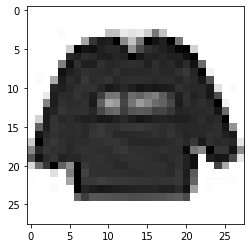

In [ ]:
plt.imshow(train_pixel[0], cmap = 'gray_r')
plt.show()

픽셀 데이터를 이용해 CNN 모델을 훈련하고자 한다. 훈련된 모델로 픽셀 데이터의 label을 예측해본다.  
  
모델을 훈련하기 앞서 데이터를 scale한다. 1\~255 사이의 데이터를 훈련하면 weight의 변동성이 커질 수 있어 이를 0\~1 사이의 값으로 맞추기 위해 각 픽셀값에 255를 나눠준다.
  
또한 CNN 모델에 훈련하기 위해 픽셀 데이터에 층을 추가한다. 컬러 데이터라면 RGB의 3개 층을 사용했겠지만, 흑백 데이터이므로 1개의 층만을 사용한다.

In [ ]:
# 훈련 데이터와 테스트 데이터 scale, 층 추가
train_scaled = train_pixel.reshape(-1, 28, 28, 1) / 255.0
test_scaled = test_pixel.reshape(-1, 28, 28, 1) / 255.0

print(train_scaled.shape, test_scaled.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


모델 훈련중 모델을 검증하기 위한 검증 데이터를 훈련 데이터에서 분리한다. 훈련 데이터의 20%를 무작위로 뽑아 검증 데이터로 분리한다. 

In [ ]:
# 훈련 데이터에서 검증 데이터 분리
train_scaled_seperated, val_scaled, train_label_seperated, val_label = train_test_split(
    train_scaled, train_label, test_size = 0.2, random_state = 100
)

In [ ]:
print(train_scaled_seperated.shape, val_scaled.shape)
print(train_label_seperated.shape, val_label.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


### 모델 훈련

CNN 모델을 만든다. 모델은 3개 층의 합성곱 신경망과 1개의 일반 신경망(output)층으로 이루어져있다. 각각의 합성곱 층에는 (2, 2) max pooling을 사용하였다. 

In [ ]:
# CNN 모델 만들기
model = Sequential()

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model.add(Conv2D(32, kernel_size = 3, activation='relu',
                 padding='same', input_shape=(28, 28, 1))) # 흑백 데이터이므로 1개의 층 사용

# (2, 2) max pooling
model.add(MaxPool2D(2))

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding='same'))

# (2, 2) max pooling
model.add(MaxPool2D(2))

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding='same'))

# (2, 2) max pooling
model.add(MaxPool2D(2))

# 2차원 데이터를 1차원으로 변환
model.add(Flatten())

# output층, 10개 label의 분류를 위해 활성화 함수는 Softmax 적용
model.add(Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)              

모델을 컴파일 하고 훈련한다. 최적화 알고리즘은 ADAM을 이용했고 손실함수는 크로스 엔트로피를 사용했다.

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

# 2번의 에포크 동안 검증 점수가 개선되지 않을 경우 훈련을 조기종료하고 최적의 에포크로 되돌아감
earlystopping = EarlyStopping(patience = 2, restore_best_weights=True)

# 모델 훈련
history1 = model.fit(train_scaled_seperated, train_label_seperated, epochs = 20, validation_data = (val_scaled, val_label), 
                     callbacks = [earlystopping])

Epoch 1/20
1500/1500 [==============================] - 36s 3ms/step - loss: 0.5507 - accuracy: 0.8015 - val_loss: 0.4135 - val_accuracy: 0.8519
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3518 - accuracy: 0.8721 - val_loss: 0.3254 - val_accuracy: 0.8841
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3100 - accuracy: 0.8881 - val_loss: 0.3197 - val_accuracy: 0.8886
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2817 - accuracy: 0.8978 - val_loss: 0.2891 - val_accuracy: 0.8995
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2636 - accuracy: 0.9044 - val_loss: 0.2728 - val_accuracy: 0.9032
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2464 - accuracy: 0.9111 - val_loss: 0.2631 - val_accuracy: 0.9067
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2339 - accuracy: 0.9154 - val_loss: 0.2661 - val_accuracy

8번째 에포크에서 검증 점수가 개선되지 않아 조기종료 되고 6번째 에포크의 모델이 채택되었다. 모델의 검증 점수는 0.2661이고, accuracy는 0.9067이다.  
  
테스트 데이터를 적용하여 모델을 예측한 결과는 다음과 같다. 

In [ ]:
model.evaluate(test_scaled, test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.2572 - accuracy: 0.9074


[0.2572263181209564, 0.9074000120162964]

0.9074의 accuracy가 나왔다.

### 모델 개선

모델의 accuracy를 개선하기 위해 hidden layer의 합성곱 층 하나를 없애는 방법을 생각할 수 있다. 
합성곱 신경망층 2개와 일반 신경망 층 1개를 이용해 모델을 만들어본다. 

In [ ]:
# 합성곱 층을 2개만 사용
model2 = Sequential()

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model2.add(Conv2D(32, kernel_size = 3, activation='relu',
                 padding='same', input_shape=(28, 28, 1)))

# (2, 2) max pooling
model2.add(MaxPool2D(2))

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model2.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding='same'))

# (2, 2) max pooling
model2.add(MaxPool2D(2))

# 2차원 데이터를 1차원으로 변환
model2.add(Flatten())

# output층, 10개 label의 분류를 위해 활성화 함수는 Softmax 적용
model2.add(Dense(10, activation = 'softmax'))

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                15690     
Total params: 25,258
Trainable params: 25,258
Non-trainable params: 0
__________________________________________________

마찬가지로 수정된 모델을 컴파일하고 훈련한다. 

In [ ]:
# 모델 컴파일
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

# 모델 훈련
history2 = model2.fit(train_scaled_seperated, train_label_seperated, epochs = 20, validation_data = (val_scaled, val_label), 
                     callbacks = [earlystopping])

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4916 - accuracy: 0.8225 - val_loss: 0.3726 - val_accuracy: 0.8633
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3347 - accuracy: 0.8817 - val_loss: 0.3161 - val_accuracy: 0.8910
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2940 - accuracy: 0.8947 - val_loss: 0.2823 - val_accuracy: 0.9011
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2701 - accuracy: 0.9036 - val_loss: 0.2774 - val_accuracy: 0.9022
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2486 - accuracy: 0.9115 - val_loss: 0.2803 - val_accuracy: 0.9013
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2322 - accuracy: 0.9160 - val_loss: 0.2531 - val_accuracy: 0.9105
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2173 - accuracy: 0.9209 - val_loss: 0.2597 - val_accuracy:

12번째 에포크에서 검증점수가 개선되지 않아 조기종료되고 10번째 에포크의 모델이 채택되었다. 모델의 검증점수는 0.2435, accuracy는 0.9143으로 이전 모델보다 개선되었음을 알 수 있다.  
  
테스트 데이터를 적용하여 모델을 예측한 결과는 다음과 같다.

In [ ]:
model2.evaluate(test_scaled, test_label)

313/313 [==============================] - 1s 2ms/step - loss: 0.2357 - accuracy: 0.9158


[0.23568877577781677, 0.9157999753952026]

테스트 데이터에 대한 accuracy는 0.9158로 이전 모델보다 더 좋아졌음을 볼 수 있다.

모델의 accuracy를 더 향상 시키기 위해 합성곱 층에서 사용하는 필터의 개수를 늘리는 방법을 생각해 볼 수 있다. 첫번째 합성곱 층에서 사용하는 필터의 개수를 32개에서 64개로 늘려본 다음 모델을 훈련시켜본다. 

In [ ]:
# 첫번째 합성곱 층의 필터를 64개 사용
model3 = Sequential()

# 합성곱 층: (3, 3) 사이즈의 64개 필터, same padding 적용, 활성화함수로 ReLU 적용
model3.add(Conv2D(64, kernel_size = 3, activation='relu',
                 padding='same', input_shape=(28, 28, 1)))

# (2, 2) max pooling
model3.add(MaxPool2D(2))

# 합성곱 층: (3, 3) 사이즈의 32개 필터, same padding 적용, 활성화함수로 ReLU 적용
model3.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding='same'))

# (2, 2) max pooling
model3.add(MaxPool2D(2))

# 2차원 데이터를 1차원으로 변환
model3.add(Flatten())

# output층, 10개 label의 분류를 위해 활성화 함수는 Softmax 적용
model3.add(Dense(10, activation = 'softmax'))

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                15690     
Total params: 34,794
Trainable params: 34,794
Non-trainable params: 0
__________________________________________________

마찬가지로 수정된 모델을 컴파일하고 훈련한다. 

In [ ]:
# 모델 컴파일
model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

# 모델 훈련
history3 = model3.fit(train_scaled_seperated, train_label_seperated, epochs = 20, validation_data = (val_scaled, val_label), 
                     callbacks = [earlystopping])

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4803 - accuracy: 0.8264 - val_loss: 0.3485 - val_accuracy: 0.8772
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3250 - accuracy: 0.8843 - val_loss: 0.2995 - val_accuracy: 0.8942
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2811 - accuracy: 0.8999 - val_loss: 0.2761 - val_accuracy: 0.9007
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2533 - accuracy: 0.9087 - val_loss: 0.2812 - val_accuracy: 0.8995
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2297 - accuracy: 0.9177 - val_loss: 0.2537 - val_accuracy: 0.9099
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2138 - accuracy: 0.9223 - val_loss: 0.2559 - val_accuracy: 0.9093
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1986 - accuracy: 0.9281 - val_loss: 0.2431 - val_accuracy:

9번째 에포크에서 검증점수가 개선되지 않아 조기종료되고 7번째 에포크의 모델이 채택되었다. 모델의 검증점수는 0.2431, accuracy는 0.9141으로 이전 모델보다 뚜렷하게 개선되었다고 보기 어렵다.  
  
테스트 데이터를 적용하여 모델을 예측한 결과는 다음과 같다.

In [ ]:
model3.evaluate(test_scaled, test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.2396 - accuracy: 0.9159


[0.23964279890060425, 0.9158999919891357]

accuracy는 0.9159로 두번째 모델보다 뚜렷하게 개선되었다고 보기 어렵고 비슷한 성능을 가진다고 할 수 있다.

### 분석 및 결론

첫번째 모델 `model`과 두번째 모델 `model2`의 차이는 합성곱 신경망 층의 개수이다. 두 모델의 `.summary()`를 비교해보았을때 합성곱 층은 하나가 줄었지만 모델의 전체 parameter 개수는 오히려 늘어난 것을 볼 수 있다. 
   
첫번째 모델에서 데이터가 마지막 합성곱 층을 통과하였을 때 데이터의 shape는 (3, 3, 32)였다. 각 필터당 9(=3x3)개의 데이터를 이용해 분류하기에는 데이터의 특징적인 부분이 부족해보인다.
max pooling은 데이터의 특징적인 부분을 제외한 나머지를 제거함으로써 이를 부각시켜주고 모델의 훈련을 용이하게 하지만, 과도하게 사용하였을 경우 데이터의 손실을 가져온다는 점을 알 수 있다.  
  
두번째 모델 `model2`와 세번째 모델 `model3`의 차이는 합성곱 신경망 층의 필터의 개수다. 필터의 개수가 늘어나면서 전체 parameter 개수도 늘어났지만 모델은 크게 개선되지 않았다. 10가지 옷 종류를 분류하는데 필터는 32개로 이미 충분하고 필터를 과도하게 늘리면 오히려 분류 능력을 방해할 수 있음을 알 수 있다. 

### 참고자료

 - "Fashin MNIST", *kaggle*, 2017년 12월 7일 수정, 2021년 6월 12일 접속, https://www.kaggle.com/zalando-research/fashionmnist
 - 박재우 교수님, *Convolutional Neural Networks* (딥러닝 수업자료, 2021-1학기)
 - 박재우 교수님, *Demo5_tensorflow_CIFAR_Tutorial.ipynb* (딥러닝 수업자료 2021-1학기)
 - 박해선, *혼자 공부하는 머신러닝 + 딥러닝* (한빛미디어, 2021), 444-460